## 의사결정나무

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#나무 구조 생성 및 저장
from sklearn.tree import export_graphviz

#나무 구조 시각화(.dot 확장자 파일 불러오기)
import graphviz

#데이터 분할 : train, test
from sklearn.model_selection import train_test_split

#예측/회귀 decision tree
from sklearn.tree import DecisionTreeRegressor

#최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

In [2]:
!pip install graphviz

In [3]:
import os

os.environ['PATH'] += os.pathsep + '/home/piai/anaconda3/lib/python3.8/site-packages'

In [4]:
matplotlib.rc('font', family = 'NanumGothic')

### STEP1 데이터 구성하기

In [5]:
df_raw = pd.read_csv('/home/piai/Downloads/체질검사.csv', engine = 'python')
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [6]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw['FAT']
df_raw_x = df_raw.drop('FAT', axis = 1 , inplace = False)


* 데이터 분할 ( train, test 데이터 7:3 으로 분할)

In [7]:
#train_test_split (X : 설명변수 데이터, Y : 목표변수 데이터, test_size = test 데이터 비율, random_state : random seed)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size = 0.3, random_state = 1234)
print(f'train data X size :{df_train_x.shape}')
print(f'train data Y size :{df_train_y.shape}')
print(f'test data X size :{df_test_x.shape}')
print(f'test data Y size :{df_test_y.shape}')

train data X size :(176, 13)
train data Y size :(176,)
test data X size :(76, 13)
test data Y size :(76,)


* 기본 옵션으로 모델 생성

In [8]:
#모델 생성
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

#train 데이터 설명력
print('Score on training set : {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))


#test 데이터 설명력
print('Score on test set : {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set : 1.000
Score on test set : 0.345


* train 데이터는 설명력이 100%인 반면 test 데이터의 설명력은 아주 낮음. => 오버피팅, 과적합

### STEP2 모델 parameter 조정

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [9]:
#train 및 test 설명력 결과 저장
train_score = []
test_score = []

#min_samples_leaf : 잎사귀 최소 자료 수 * 참조 : para_leaf : [1,2,3,...,19]

para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]
for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234 , min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
#결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [10]:
#모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.345
1,2,0.970,0.374
2,3,0.928,0.445
3,4,0.902,0.447
4,5,0.868,0.451
5,6,0.851,0.447
6,7,0.843,0.465
7,8,0.830,0.536
8,9,0.802,0.477
9,10,0.793,0.505


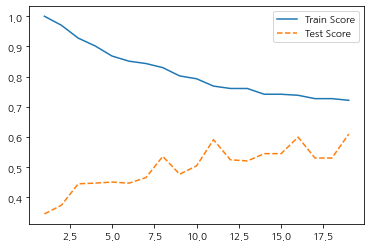

In [11]:
#모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = "--", label = 'Test Score')
plt.legend()

최소 자료수가 커짐에 따라서 test는 높아지고 train은 낮아짐. gap이 가장 적절한 위치를 찾아야! => 2개 뽑기, 잎사귀 수 8, 16 두번

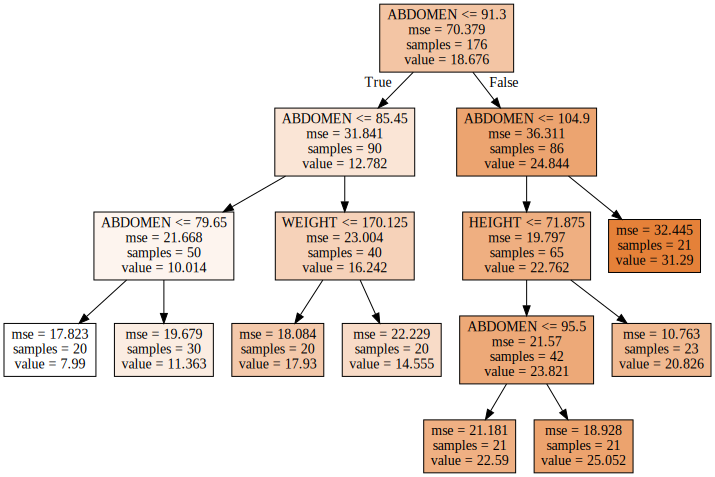

In [12]:
#변수명 저장
v_feature_name = df_train_x.columns

#노드의 최소 자료 수 = 8 모델
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 20)
tree_graph.fit(df_train_x , df_train_y)
export_graphviz(tree_graph, out_file = 'tree_leaf.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [16]:
#train 및 test 설명력 결과 저장
train_score = []
test_score = []

#min_samples_split : 분리노드 최소 자료 수 * 참조 : para_split : [1,2,3,...,19]

para_split = [n_split * 2 for n_split in range(2,20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state = 1234,
                                 min_samples_leaf = 8,
                                 min_samples_split = v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

#결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.830,0.536
1,6,0.830,0.536
2,8,0.830,0.536
3,10,0.830,0.536
4,12,0.830,0.536
5,14,0.830,0.536
6,16,0.830,0.536
7,18,0.821,0.557
8,20,0.813,0.581
9,22,0.792,0.567


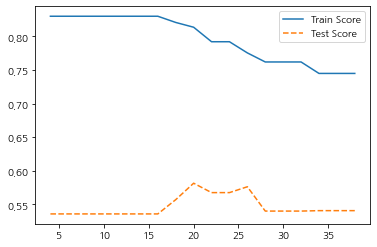

In [20]:
#모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_split, test_score, linestyle = "--", label = 'Test Score')
plt.legend()

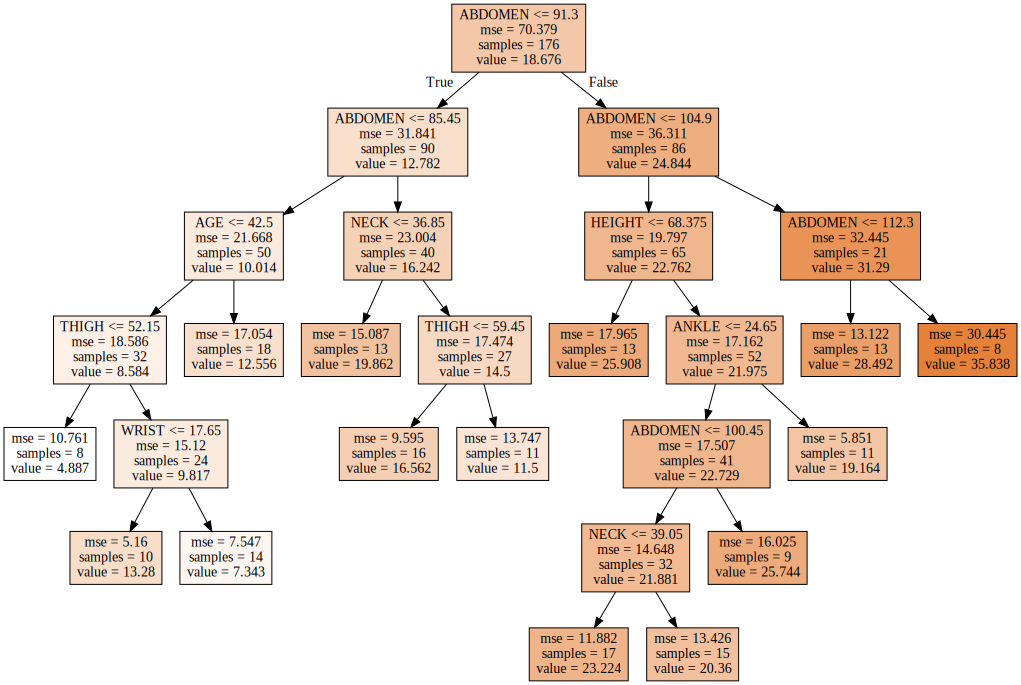

In [27]:
#변수명 저장
v_feature_name = df_train_x.columns

#분리 노드의 최소 자료 수 = 20 모델
tree_graph = DecisionTreeRegressor(min_samples_leaf = 8,
                                  min_samples_split = 20,
                                  random_state = 1234)
tree_graph.fit(df_train_x , df_train_y)
    
export_graphviz(tree_graph, out_file = 'tree_split.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_split.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### Max_depth : 최대 깊이 변경에 따른 모델 성능

In [59]:
#train 및 test 설명력 결과 저장
train_score = []
test_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state = 1234,
                                 min_samples_leaf = 8,
                                 min_samples_split = 20,
                                 max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

#결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.517,0.333
1,2,0.679,0.569
2,3,0.749,0.538
3,4,0.783,0.570
4,5,0.808,0.581
5,6,0.813,0.581
6,7,0.813,0.581
7,8,0.813,0.581
8,9,0.813,0.581
9,10,0.813,0.581


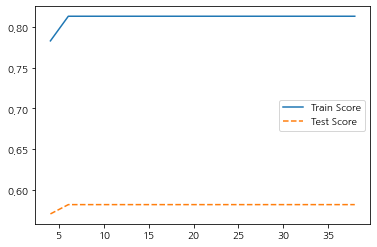

In [51]:
#모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = "--", label = 'Test Score')
plt.legend()

In [1]:
#변수명 저장
v_feature_name = df_train_x.columns

#최대 깊이 = 2 모델
tree_graph = DecisionTreeRegressor(min_samples_leaf = 8,
                                  min_samples_split = 20,
                                   max_depth = 2,
                                  random_state = 1234)
tree_graph.fit(df_train_x , df_train_y)
    
export_graphviz(tree_graph, out_file = 'tree_depth.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_depth.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

NameError: name 'df_train_x' is not defined

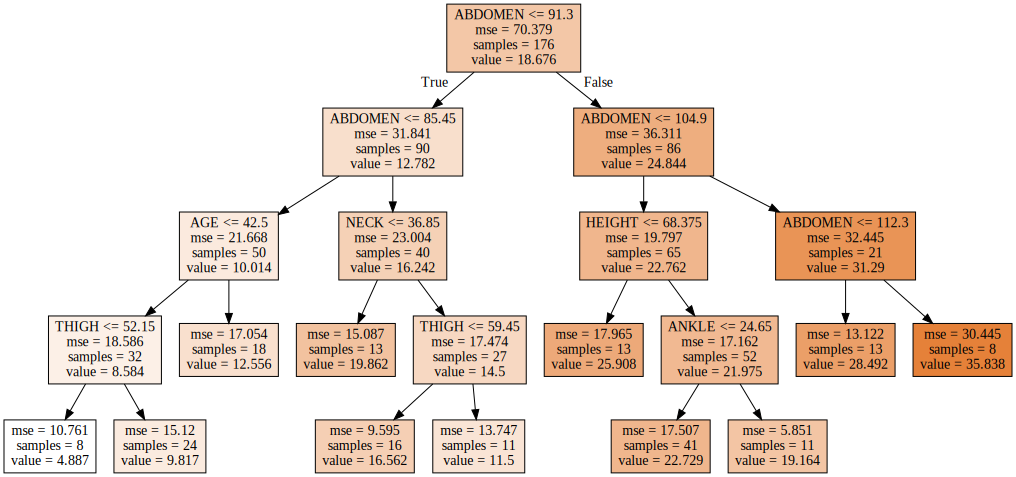

In [53]:
#변수명 저장
v_feature_name = df_train_x.columns

#최대 깊이 = 4 모델
tree_graph = DecisionTreeRegressor(min_samples_leaf = 8,
                                  min_samples_split = 20,
                                   max_depth = 4,
                                  random_state = 1234)
tree_graph.fit(df_train_x , df_train_y)
    
export_graphviz(tree_graph, out_file = 'tree_depth.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_depth.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### STEP3 최종 모델 선정

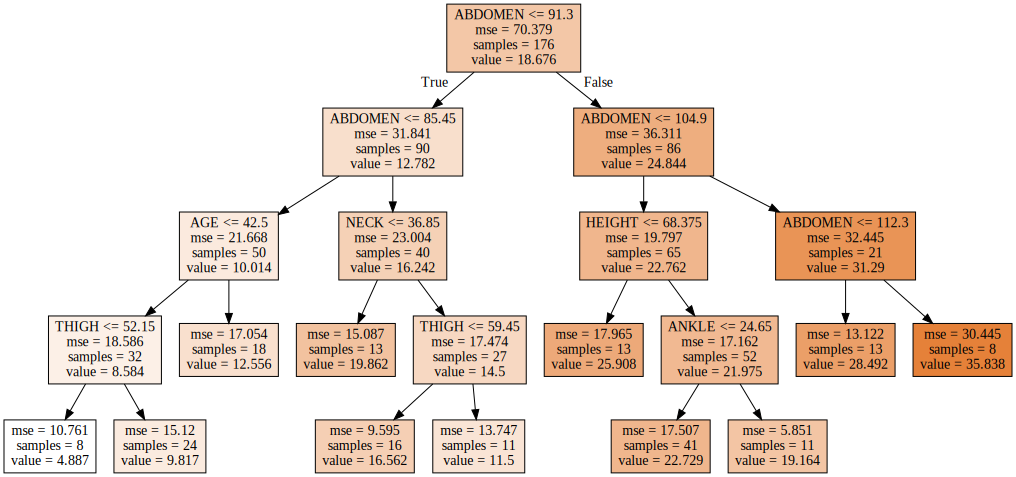

In [54]:
tree_final = DecisionTreeRegressor(min_samples_leaf = 8, min_samples_split = 20, max_depth = 4, random_state = 1234)
tree_final.fit(df_train_x, df_train_y)

export_graphviz(tree_final, out_file = 'tree_final.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [55]:
#feature_importances_ : 설명변수의 중요도
#tree_final, feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

#df_feature_importance 의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
5,ABDOMEN,0.895
7,THIGH,0.032
3,NECK,0.026
0,AGE,0.019
2,HEIGHT,0.017
9,ANKLE,0.011
1,WEIGHT,0.000
4,CHEST,0.000
6,HIP,0.000
8,KNEE,0.000


Text(0, 0.5, '변수')

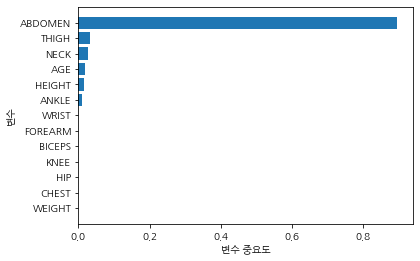

In [56]:
#설명변수 중요도 그래프, 중요도가 높은 변수를 상위에 그림
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [57]:
#모델 생성
tree_final = DecisionTreeRegressor(min_samples_leaf = 8, min_samples_split = 20, max_depth = 4, random_state = 1234)
tree_final.fit(df_train_x, df_train_y)

#train 데이터 설명력
print('Score on training set : {:.3f}'.format(tree_final.score(df_train_x, df_train_y)))

#test 데이터 설명력
print('Score on test set : {:.3f}'.format(tree_final.score(df_test_x, df_test_y)))

Score on training set : 0.783
Score on test set : 0.570
